In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np

In [2]:
FILE = 'rdd_clean.parq.gzip'

sns.set_style("darkgrid")
pd.options.display.max_columns = 100

In [3]:
data = pd.read_parquet(FILE)
data.head()

,spend_1m_baby,spend_2m_baby,spend_3m_baby,spend_4m_baby,spend_5m_baby,spend_6m_baby,spend_1m_clothes,spend_2m_clothes,spend_3m_clothes,spend_4m_clothes,spend_5m_clothes,spend_6m_clothes,spend_1m_health,spend_2m_health,spend_3m_health,spend_4m_health,spend_5m_health,spend_6m_health,spend_1m_pet,spend_2m_pet,spend_3m_pet,spend_4m_pet,spend_5m_pet,spend_6m_pet,spend_1m_groceries,spend_2m_groceries,spend_3m_groceries,spend_4m_groceries,spend_5m_groceries,spend_6m_groceries,spend_1m_eletronic,spend_2m_eletronic,spend_3m_eletronic,spend_4m_eletronic,spend_5m_eletronic,spend_6m_eletronic,sales,discount,profit,age,gender,cust_state,tenure
0,5,0,0,0,10,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,55,180,20.000000,10.000000,15.0,40.0,0,0,0,0.0,0.0,0.0,1442.30,4.0,66.93,30,0.0,MA,19
1,0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0.000000,0.000000,0.0,0.0,0,0,0,0.0,0.0,0.0,883.96,2.0,41.33,30,1.0,MG,20
2,0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,25,10,254.255197,289.255197,65.0,30.0,0,0,0,0.0,0.0,0.0,4900.67,224.0,15.88,29,0.0,RJ,21
3,0,0,0,0,0,0.0,25,25.0,0.0,25.0,25.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,30,10,5.000000,30.000000,0.0,45.0,0,0,0,0.0,0.0,0.0,1547.48,1.0,74.99,36,1.0,BA,18
4,0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,40,0,0.000000,10.000000,0.0,45.0,0,0,0,0.0,0.0,0.0,1335.23,13.0,52.41,37,0.0,PB,19


In [4]:
cutoff = 19
data['above_threshold'] = (data['tenure'] > cutoff).astype(int)

In [14]:
def triag_kernel(R, c=0, h=3):
    return (np.abs(R-c) <= h) * (1 - np.abs(R-c)/h)


np.testing.assert_allclose(triag_kernel(np.array([1,2,3,4,5]), 3, 2), np.array([0. , 0.5, 1. , 0.5, 0. ]))

In [16]:
np.testing.assert_allclose(
    triag_kernel(data['tenure'], 19, 4),
    triag_kernel(data['tenure']-19, 0, 4)
)

In [27]:
weights = triag_kernel(data['tenure'], c=19, h=4)
formula = 'profit ~ tenure + above_threshold + tenure:above_threshold'
fit = smf.wls(formula, data=data, weights=weights).fit()
fit.summary()

/opt/homebrew/Caskroom/miniforge/base/envs/causal/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:792: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.008
Model:                            WLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     27.51
Date:                Fri, 09 Dec 2022   Prob (F-statistic):           1.04e-17
Time:                        08:22:35   Log-Likelihood:                   -inf
No. Observations:               10000   AIC:                               inf
Df Residuals:                    9996   BIC:                               inf
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 47.6385     14.532      3.278      0.001      19.152      76.125
tenure                     0.2974      0.788      0.377      0.706      -1.247       1.842
above_threshold          -10.3266     21.887     -0.472      0.637     -53.229      32.575
tenure:above_threshold     0.1060      1.117      0.095      0.924      -2.083       2.295
==============================================================================
Omnibus:                     8361.040   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1159221.026
Skew:                           3.341   Prob(JB):                         0.00
Kurtosis:                      55.321   Cond. No.                     1.37e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.37e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [28]:
by_tenure = data.groupby('tenure')['profit', 'above_threshold'].mean().reset_index()
by_tenure

/var/folders/36/gj41c8c14fnflx3h38bncgqm0000gn/T/ipykernel_58337/3449442871.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  by_tenure = data.groupby('tenure')['profit', 'above_threshold'].mean().reset_index()


,tenure,profit,above_threshold
0,15,52.723939,0.0
1,16,53.821772,0.0
2,17,52.782111,0.0
3,18,52.680398,0.0
4,19,53.393001,0.0
5,20,45.844495,1.0
6,21,44.487213,1.0
7,22,47.701012,1.0
8,23,44.601138,1.0
9,24,43.279330,1.0


In [29]:
by_tenure['predicted'] = fit.predict(by_tenure)
by_tenure

,tenure,profit,above_threshold,predicted
0,15,52.723939,0.0,52.098805
1,16,53.821772,0.0,52.396156
2,17,52.782111,0.0,52.693506
3,18,52.680398,0.0,52.990857
4,19,53.393001,0.0,53.288208
5,20,45.844495,1.0,45.378963
6,21,44.487213,1.0,45.782313
7,22,47.701012,1.0,46.185663
8,23,44.601138,1.0,46.589013
9,24,43.279330,1.0,46.992363


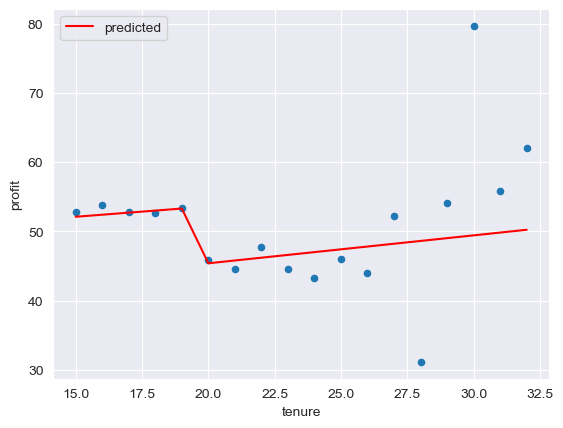

In [30]:
ax = by_tenure.plot(x='tenure', y='profit', kind='scatter')
by_tenure.plot(x='tenure', y='predicted', kind='line', ax=ax, color='red')
plt.ylabel('profit')
plt.show()